In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [2]:
print(f'Tensorflow version = {tf.__version__}')
print(f'{tf.config.list_physical_devices("GPU")}')

Tensorflow version = 2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
from keras import layers
from keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import os
import numpy as np
from glob import glob

In [4]:
IMG_SIZE = (300, 300, 3)
H = 300
W = 300

In [12]:
model_dir = '..\..\Model'
dataset_dir = '..\..\Dataset_Split'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [7]:
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(H, W),
        batch_size=64,
        class_mode='categorical',
        seed=42,
        )

Found 4150 images belonging to 4 classes.


In [16]:
val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(H, W),
        batch_size=64,
        class_mode='categorical',
        shuffle=False,
        # seed=42,
        )

Found 889 images belonging to 4 classes.


In [17]:
resnet_model = Sequential()

pretrained_model= ResNet50(include_top=False,
                   input_shape=IMG_SIZE,
                   pooling='avg',
                   classes=4,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(4, activation='softmax'))

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23,851,012
Trainable params: 263,044
Non-trainable params: 23,587,968
______________________________________

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)
model_save = ModelCheckpoint(filepath=os.path.join(model_dir, 'Model.hdf5'), save_best_only= True, verbose=0)

In [19]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
%%time

epochs = 15
batch_size = 32

history = resnet_model.fit(
  train_generator,
  validation_data=val_generator,
  batch_size=batch_size,
  epochs=epochs,
  verbose=1,
  callbacks=[early_stopping, model_save],
)

Epoch 1/15
65/65 [==============================] - 73s 1s/step - loss: 0.2017 - accuracy: 0.9330 - val_loss: 0.0578 - val_accuracy: 0.9921
Epoch 2/15
65/65 [==============================] - 71s 1s/step - loss: 0.0199 - accuracy: 0.9978 - val_loss: 0.0345 - val_accuracy: 0.9989
Epoch 3/15
65/65 [==============================] - 76s 1s/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 4/15
65/65 [==============================] - 79s 1s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 5/15
65/65 [==============================] - 81s 1s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 6/15
65/65 [==============================] - 81s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 7/15
65/65 [==============================] - 82s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 8/15
65/65 [==

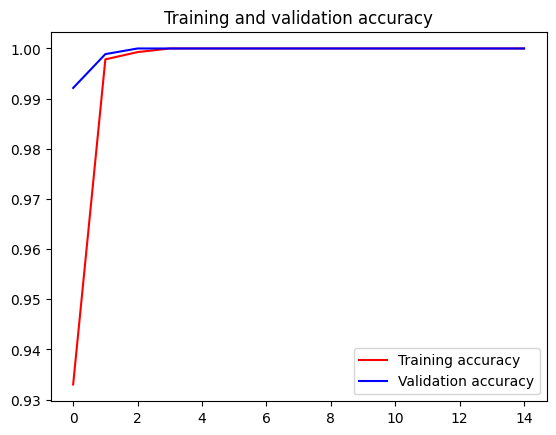

<Figure size 640x480 with 0 Axes>

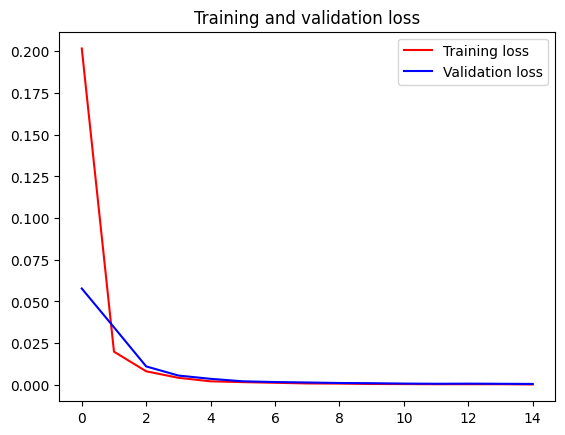

<Figure size 640x480 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [23]:
from tensorflow.keras.models import load_model

In [24]:
model = load_model(os.path.join(model_dir, 'Model.hdf5'))

In [22]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(H, W),
        batch_size=64,
        class_mode='categorical',
        shuffle=False,
        )

Found 893 images belonging to 4 classes.


In [25]:
pred = model.predict(test_generator)

14/14 [==============================] - 15s 996ms/step


In [26]:
y_pred = np.argmax(pred, axis=1)

In [27]:
y_test = []
for i in test_generator.index_array:
  y_test.append(test_generator.labels[i])
y_test = np.array(y_test)

In [31]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       239
           1     1.0000    1.0000    1.0000       217
           2     1.0000    1.0000    1.0000       240
           3     1.0000    1.0000    1.0000       197

    accuracy                         1.0000       893
   macro avg     1.0000    1.0000    1.0000       893
weighted avg     1.0000    1.0000    1.0000       893

